# Import and seed

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

import torch
import torchtuples as tt

from pycox.datasets import metabric
from pycox.models import CoxPH
from pycox.evaluation import EvalSurv

In [2]:
np.random.seed(1234)
_ = torch.manual_seed(123)

# Fetch data

In [3]:
df_train = metabric.read_df()
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

In [4]:
df_train.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,duration,event
0,5.603834,7.811392,10.797988,5.967607,1.0,1.0,0.0,1.0,56.840000,99.333336,0
1,5.284882,9.581043,10.204620,5.664970,1.0,0.0,0.0,1.0,85.940002,95.733330,1
3,6.654017,5.341846,8.646379,5.655888,0.0,0.0,0.0,0.0,66.910004,239.300003,0
4,5.456747,5.339741,10.555724,6.008429,1.0,0.0,0.0,1.0,67.849998,56.933334,1
5,5.425826,6.331182,10.455145,5.749053,1.0,1.0,0.0,1.0,70.519997,123.533333,0


# Preprocess data

In [5]:
cols_standardize = ['x0', 'x1', 'x2', 'x3', 'x8']
cols_leave = ['x4', 'x5', 'x6', 'x7']

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

In [6]:
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

In [7]:
get_target = lambda df: (df['duration'].values, df['event'].values)
y_train = get_target(df_train)
y_val = get_target(df_val)
durations_test, events_test = get_target(df_test)
val = x_val, y_val

# Neural network and CoxPH (DeepCox) model

In [8]:
in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = 1
batch_norm = True
dropout = 0.1
output_bias = False

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm,
                              dropout, output_bias=output_bias)

device = "cuda" if torch.cuda.is_available()  else "mps" if torch.backends.mps.is_available() else "cpu"
print('Device: ', device)

model = CoxPH(net, tt.optim.Adam, device=device)

Device:  mps


# Train model

## Select learning rate

Best learning rate:  0.0613590727341321


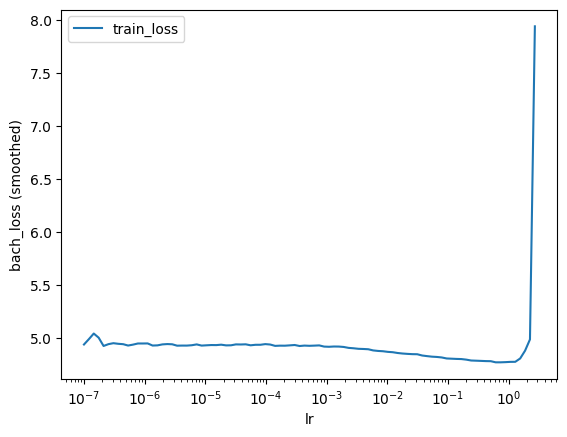

In [9]:
batch_size = 256
lrfinder = model.lr_finder(x_train, y_train, batch_size, tolerance=10)
_ = lrfinder.plot()
print('Best learning rate: ', lrfinder.get_best_lr())

In [10]:
model.optimizer.set_lr(0.01)

## Set additional training configuration

In [11]:
epochs = 512
callbacks = [tt.callbacks.EarlyStopping()]
verbose = True

## Fit

In [12]:
%%time
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                val_data=val, val_batch_size=batch_size)

0:	[1s / 1s],		train_loss: 4.7998,	val_loss: 3.9366
1:	[0s / 1s],		train_loss: 4.6817,	val_loss: 3.9195
2:	[0s / 1s],		train_loss: 4.6410,	val_loss: 3.9444
3:	[0s / 1s],		train_loss: 4.6154,	val_loss: 3.9377
4:	[0s / 1s],		train_loss: 4.6087,	val_loss: 3.9278
5:	[0s / 1s],		train_loss: 4.5896,	val_loss: 3.9376
6:	[0s / 1s],		train_loss: 4.5818,	val_loss: 3.9445
7:	[0s / 1s],		train_loss: 4.5755,	val_loss: 3.9428
8:	[0s / 1s],		train_loss: 4.5799,	val_loss: 3.9315
9:	[0s / 1s],		train_loss: 4.5753,	val_loss: 3.9328
10:	[0s / 2s],		train_loss: 4.5638,	val_loss: 3.9353
11:	[0s / 2s],		train_loss: 4.5582,	val_loss: 3.9471
CPU times: user 649 ms, sys: 90 ms, total: 739 ms
Wall time: 2.09 s


Partial log likelihood:  -4.981461


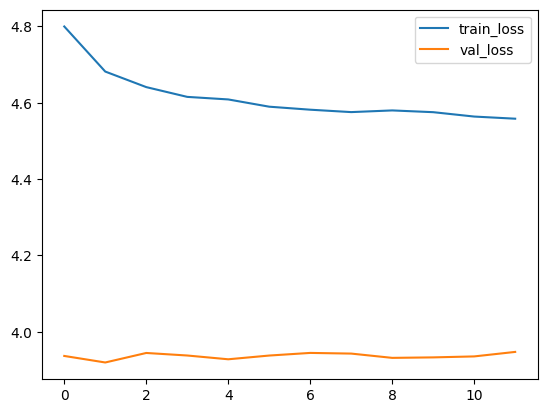

In [13]:
_ = log.plot()
partial_log_likelihood = model.partial_log_likelihood(*val).mean()
print('Partial log likelihood: ', partial_log_likelihood)

## Predict

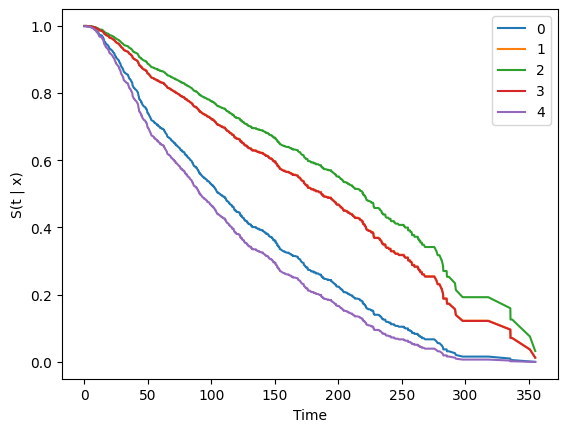

In [14]:
_ = model.compute_baseline_hazards()
surv = model.predict_surv_df(x_test)
surv.iloc[:, :5].plot()
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

# Evaluate model

/Users/Matteo.Fordiani/Code/PythonWorkspace/federated-survival-analysis/federated-survival-tutorial/.venv/lib/python3.8/site-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


Concordance likelihood:  0.6512544499067638
Integrated Briers score:  0.16690648973123662
Binomial log likelihood:  0.4943163479215658


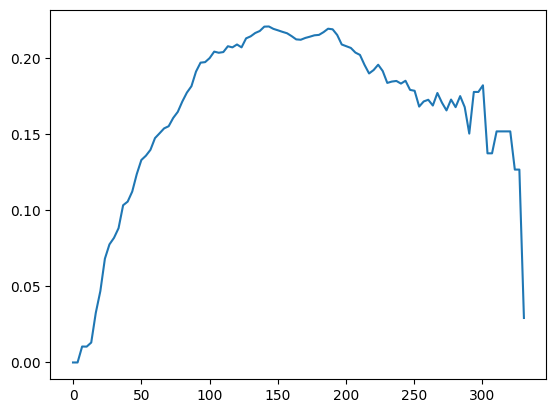

In [15]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
_ = ev.brier_score(time_grid).plot()

print('Concordance likelihood: ', ev.concordance_td())
print('Integrated Briers score: ', ev.integrated_brier_score(time_grid))
print('Binomial log likelihood: ', ev.integrated_nbll(time_grid))
